In [1]:
!pip install -q transformers==4.43.3
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00


In [2]:
!pip install -q seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
from tqdm import tqdm

from seqeval.metrics import classification_report, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer
from transformers import DataCollatorForSeq2Seq

In [4]:
ds = load_dataset("xtreme", name = "PAN-X.en")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/131k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/942k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/472k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
ds.set_format("pandas")

In [6]:
df_train = ds["train"][:]

In [7]:
df_train["num_tokens"] = df_train["tokens"].apply(len)

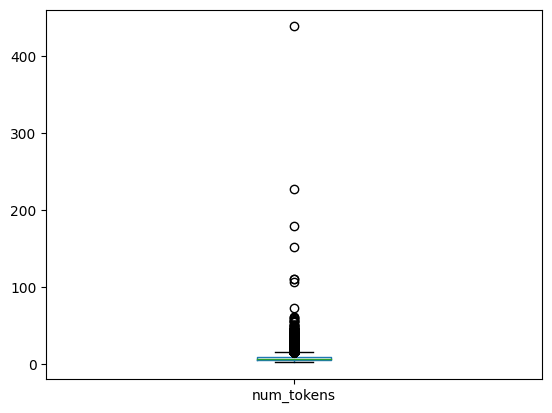

In [8]:
# BOXPLOT
df_train.boxplot("num_tokens", grid = False)
plt.show()

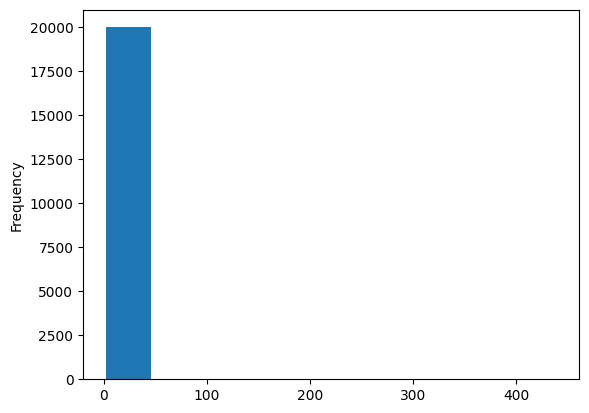

In [9]:
# HISTOGRAM
df_train["num_tokens"].plot(kind = "hist")
plt.show()

In [10]:
ds.reset_format()

In [11]:
model_ckpt = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [12]:
for k, v in ds["train"][150].items():
    print(k)
    print(v)
    print("\n")

tokens
['It', 'is', 'on', 'the', 'Campaign', 'for', 'Real', 'Ale', "'s", 'National', 'Inventory', 'of', 'Historic', 'Pub', 'Interiors', '.']


ner_tags
[0, 0, 0, 0, 3, 4, 4, 4, 0, 3, 4, 4, 4, 4, 4, 0]


langs
['en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en', 'en']




In [13]:
def tokenize_and_align(row):
    inputs = tokenizer(row["tokens"], truncation = True, is_split_into_words = True)
    word_ids = inputs.word_ids()
    ner_tags = row["ner_tags"]
    labels = []
    p_id = None

    for w_id in word_ids:
        if w_id is not None and p_id != w_id:
            labels.append(ner_tags[w_id])
            p_id = w_id
        else:
            labels.append(-100)

    return {"labels" : labels, **inputs}

In [14]:
idx = 24
out = tokenize_and_align(ds["train"][idx])
print(out["labels"])
# print(out["word_ids"])
print(ds["train"][idx]["ner_tags"])

[-100, 0, 0, -100, -100, 0, 0, 1, -100, 2, -100, 0, -100]
[0, 0, 0, 0, 1, 2, 0]


In [15]:
ds_tokenized = ds.map(tokenize_and_align)
ds_tokenized = ds_tokenized.remove_columns(column_names = ['tokens', 'langs', 'token_type_ids', 'ner_tags'])

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [16]:
use_cuda = True
device = "cuda" if torch.cuda.is_available() and use_cuda else "cpu"
device

'cuda'

In [17]:
warnings.filterwarnings("ignore")
bert_model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [18]:
tags = ds["train"].features["ner_tags"].feature
tags

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)

In [19]:
class NERModel(nn.Module):
    def __init__(self, bert_model, num_tags, dropout = 0.1):
        super().__init__()
        self.bert_model = bert_model
        self.dropout = nn.Dropout(p = dropout)
        self.act = nn.GELU()
        self.output = nn.Linear(bert_model.config.hidden_size, num_tags)

    def forward(self, inputs):
        logits = self.bert_model(**inputs).last_hidden_state
        return self.output(self.dropout(self.act(logits)))

In [20]:
ner_model = NERModel(bert_model, len(tags.names)).to(device)

In [21]:
def infer_model(model, inputs):
    inputs = {k : v.to(device) for k, v in inputs.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        logits = model(inputs)
    return logits

In [22]:
batch_size = 64
data_collator = DataCollatorForSeq2Seq(tokenizer, return_tensors = "pt")

inputs = ds_tokenized["train"][:4]
inputs = [dict(zip(inputs, t)) for t in zip(*inputs.values())]
data_collator(inputs)

{'input_ids': tensor([[  101,   155,   119,   145,   119, 16029,   113,  1457,   119,  4898,
          1595,   114,   113,  5306,  1604, 13277,   114,   102],
        [  101,   132,   112,   112,   112, 16357, 12221,  3680, 26305,   112,
           112,   112,   102,     0,     0,     0,     0,     0],
        [  101,  5728,   152,  2707,   148,  1605,  1361,  1403, 16835,  2956,
           113,  1255,  2477,   114,   102,     0,     0,     0],
        [  101,  3608,  1392,   117,  1203,  3308,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'labels': tensor([[-100,    3, -100, -100, -100,    4,    0,    3, -100,    4,    4,    0,
            0,    0, -100,    0,    0

In [23]:
train_dataloader = DataLoader(dataset = ds_tokenized["train"],
                              shuffle = True,
                              batch_size = batch_size,
                              collate_fn = data_collator)


val_dataloader = DataLoader(dataset = ds_tokenized["validation"],
                            shuffle = True,
                            batch_size = batch_size,
                            collate_fn = data_collator)

In [24]:
def align_predictions(logits, labels):
    preds = logits.argmax(dim = -1)
    pred_labels = []
    act_labels = []

    for i, row in enumerate(labels):
        pred_label = []
        act_label = []
        for j, label in enumerate(row):
            if label != -100:
                pred_label.append(preds[i, j].item())
                act_label.append(labels[i, j].item())
        pred_labels.append(pred_label)
        act_labels.append(act_label)

    return {"act_labels" : act_labels, "pred_labels" : pred_labels}

In [25]:
loss_fn = nn.CrossEntropyLoss(ignore_index = -100)

In [26]:
def predict_and_loss(ner_model, batch):
    inputs = {k : v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    logits = ner_model(inputs)
    loss = loss_fn(logits.reshape(-1, len(tags.names)), batch["labels"].reshape(-1, ).to(device))

    out_preds = align_predictions(logits.cpu(), batch["labels"])

    preds_aligned = out_preds["pred_labels"]
    act_aligned = out_preds["act_labels"]

    preds_aligned_str = [[tags.int2str(idx) for idx in row] for row in preds_aligned]
    act_aligned_str = [[tags.int2str(idx) for idx in row] for row in act_aligned]

    acc_val = accuracy_score(y_true = act_aligned_str, y_pred = preds_aligned_str)
    f1_val = f1_score(y_true = act_aligned_str, y_pred = preds_aligned_str)

    cm = confusion_matrix([x for row in preds_aligned for x in row], [x for row in act_aligned for x in row], normalize = "true")

    return {
        "preds_aligned" : preds_aligned,
        "act_aligned" : act_aligned,
        "preds_aligned_str" : preds_aligned_str,
        "act_aligned_str" : act_aligned_str,
        "acc_val" : acc_val,
        "f1_val" : f1_val,
        "confusion_matrix" : cm,
        "loss" : loss.item()
    }

In [27]:
def plot_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tags.names)
    disp.plot(cmap = "Blues", colorbar = False, values_format = ".2f")
    plt.show()

In [28]:
def validation_eval(ner_model):
    f1_val = 0.0
    acc_val = 0.0
    val_loss = 0.0
    act_labels = []
    pred_labels = []

    for batch in tqdm(val_dataloader):
        res = predict_and_loss(ner_model, batch)
        f1_val += res["f1_val"] / len(val_dataloader)
        acc_val += res["acc_val"] / len(val_dataloader)
        val_loss += res["loss"] / len(val_dataloader)
        act_labels += [x for row in res["act_aligned"] for x in row]
        pred_labels += [x for row in res["preds_aligned"] for x in row]

    return {
        "f1_val" : f1_val,
        "acc_val" : acc_val,
        "val_loss" : val_loss,
        "act_labels" : act_labels,
        "pred_labels" : pred_labels
    }

100%|██████████| 157/157 [00:13<00:00, 11.47it/s]


Untrained eval...

f1_val : 0.018328999135109533
acc_val : 0.11518442836990653
val_loss : 1.9683694900221127



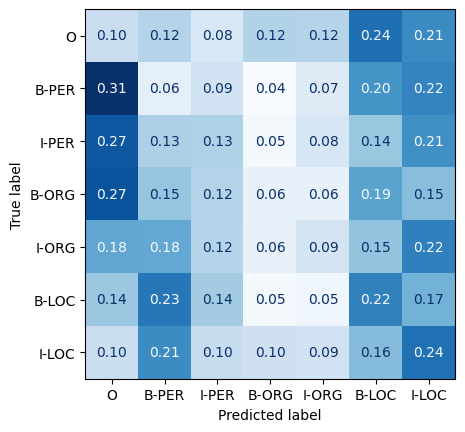

In [29]:
val_out = validation_eval(ner_model)
f1_val = val_out["f1_val"]
acc_val = val_out["acc_val"]
act_labels = val_out["act_labels"]
pred_labels = val_out["pred_labels"]
val_loss = val_out["val_loss"]

print("Untrained eval...\n")
print(f"f1_val : {f1_val}")
print(f"acc_val : {acc_val}")
print(f"val_loss : {val_loss}\n")
cm = confusion_matrix(y_true = act_labels, y_pred = pred_labels, normalize = "true")
plot_confusion_matrix(cm)

In [30]:
optimizer = torch.optim.Adam(params = ner_model.parameters(), lr = 2e-4)

In [31]:
def train_on_epoch(ner_model):
    ner_model.train()
    train_loss = 0.0

    for batch in tqdm(train_dataloader):
        inputs = {k : v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
        logits = ner_model(inputs)
        loss = loss_fn(logits.reshape(-1, len(tags.names)), batch["labels"].to(device).reshape(-1, ))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() / len(train_dataloader)

    val_out = validation_eval(ner_model)

    val_f1 = val_out["f1_val"]
    val_acc = val_out["acc_val"]
    val_loss = val_out["val_loss"]

    return {
        "train_loss" : train_loss,
        "val_loss" : val_loss,
        "val_acc" : val_acc,
        "val_f1" : val_f1
    }

In [32]:
def train(ner_model, num_epochs, best_model_path = "ner_model.pt", prev_stats = None, patience = None):
    fin_model = None
    prev_val_loss = None
    prev_best_epoch = None

    if patience == 0:
        print("patience can not be 0. Updating patience to None")
        patience = None

    if prev_stats is None:
        stats = {
            "train_losses" : [],
            "val_losses" : [],
            "val_acc_list" : [],
            "val_f1_list" : []
        }
    else:
        stats = prev_stats


    for epoch in range(num_epochs):
        if patience is not None and prev_best_epoch is not None and epoch - prev_best_epoch - 1 > patience:
            print(f"patience limit : {patience} reached.")
            print(f"Best model loss : {prev_val_loss}")
            print(f"Best model epoch : {prev_best_epoch}")


        epoch_out = train_on_epoch(ner_model)

        train_loss = epoch_out["train_loss"]
        val_loss = epoch_out["val_loss"]
        val_acc = epoch_out["val_acc"]
        val_f1 = epoch_out["val_f1"]

        stats["train_losses"].append(train_loss)
        stats["val_losses"].append(val_loss)
        stats["val_acc_list"].append(val_acc)
        stats["val_f1_list"].append(val_f1)


        print(f"For epoch : {epoch}")
        print(f"train_loss : {train_loss}")
        print(f"val_loss : {val_loss}")
        print(f"val_acc : {val_acc}")
        print(f"val_f1 : {val_f1}")


        if prev_val_loss is None or prev_val_loss >= val_loss:
            torch.save(ner_model.state_dict(), best_model_path)
            prev_val_loss = val_loss
            print(f"It is the best model as yet. Saved it to {best_model_path}")

            prev_best_epoch = epoch

        print("\n")
        print("#" * 100)
        print("\n")

    ner_model.load_state_dict(torch.load(best_model_path))
    return ner_model, stats

In [33]:
num_epochs = 4
fin_ner_model, stats = train(ner_model, num_epochs, best_model_path = "ner_model.pt", patience = 2)

100%|██████████| 157/157 [00:10<00:00, 15.05it/s]


For epoch : 0
train_loss : 0.3637483507013931
val_loss : 0.2794424831677394
val_acc : 0.9132781651606079
val_f1 : 0.7740252582134874
It is the best model as yet. Saved it to ner_model.pt


####################################################################################################




100%|██████████| 157/157 [00:10<00:00, 14.91it/s]


For epoch : 1
train_loss : 0.22881473034334626
val_loss : 0.30878622668563926
val_acc : 0.903493436236814
val_f1 : 0.7359673824585108


####################################################################################################




100%|██████████| 157/157 [00:10<00:00, 14.80it/s]


For epoch : 2
train_loss : 0.17608432966870616
val_loss : 0.32010069171524363
val_acc : 0.9106540426722317
val_f1 : 0.7717045379201924


####################################################################################################




100%|██████████| 157/157 [00:10<00:00, 14.81it/s]


For epoch : 3
train_loss : 0.14194618029811507
val_loss : 0.35608462676121194
val_acc : 0.9010934459367013
val_f1 : 0.7404304701842389


####################################################################################################




In [34]:
for k, v in stats.items():
    print(f"{k} : {v}")
    print("\n")

train_losses : [0.3637483507013931, 0.22881473034334626, 0.17608432966870616, 0.14194618029811507]


val_losses : [0.2794424831677394, 0.30878622668563926, 0.32010069171524363, 0.35608462676121194]


val_acc_list : [0.9132781651606079, 0.903493436236814, 0.9106540426722317, 0.9010934459367013]


val_f1_list : [0.7740252582134874, 0.7359673824585108, 0.7717045379201924, 0.7404304701842389]




In [35]:
def pred_ner_tags(text, ner_model):
    inputs = tokenizer(text, return_tensors = "pt")
    word_ids = inputs.word_ids()
    inputs = {k : v.to(device) for k, v in inputs.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        logits = ner_model(inputs)

    preds = logits.argmax(dim = -1).cpu().numpy().astype(np.int32)[0]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    pred_tags = tags.int2str(preds)

    cur_word = None
    cur_tag = None

    words = []
    out_tags = []
    p_id = None
    last_fill_idx = None

    for i, w_id in enumerate(word_ids):
        if w_id is None:
            if last_fill_idx is None:
                last_fill_idx = i
            continue

        if w_id == p_id:
            cur_word += tokens[i][2 :]
        else:
            if cur_word is not None:
                words.append(cur_word)
                out_tags.append(pred_tags[last_fill_idx])
                last_fill_idx = i

            cur_word = tokens[i]
            p_id = w_id


    if cur_word:
        words.append(cur_word)
        out_tags.append(pred_tags[last_fill_idx])

    res = {k : v for k, v in zip(words, out_tags) if v != "O"}

    return res

In [36]:
pred_ner_tags("Jennifer went to Paris, France to see Eiffel Tower", ner_model)

{'Paris': 'B-LOC', 'France': 'B-LOC', 'Eiffel': 'B-ORG', 'Tower': 'I-ORG'}

100%|██████████| 157/157 [00:10<00:00, 14.51it/s]


Trained eval...

f1_val : 0.7732164418018069
acc_val : 0.9124480198507381
val_loss : 0.2799595351906339



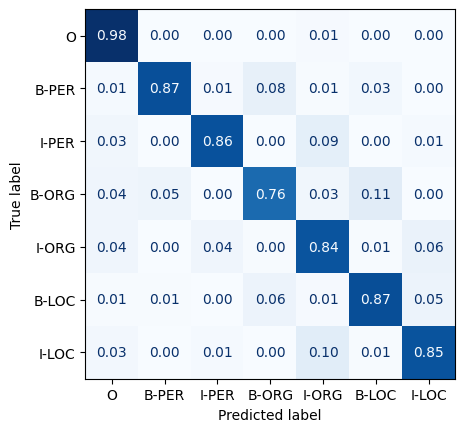

In [37]:
val_out = validation_eval(ner_model)
f1_val = val_out["f1_val"]
acc_val = val_out["acc_val"]
act_labels = val_out["act_labels"]
pred_labels = val_out["pred_labels"]
val_loss = val_out["val_loss"]

print("Trained eval...\n")
print(f"f1_val : {f1_val}")
print(f"acc_val : {acc_val}")
print(f"val_loss : {val_loss}\n")
cm = confusion_matrix(y_true = act_labels, y_pred = pred_labels, normalize = "true")
plot_confusion_matrix(cm)